In [1]:
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import grad

def Gaussian(q):
    cov = jnp.eye(2)
    covinv = jnp.linalg.inv(cov)
    return jnp.exp(-0.5 * q @ covinv @ q)

def Potential(q, L):
	return -jnp.log(L(q))

dUdq = grad(Potential, argnums=0)

def Kinetic(p, mass):
    minv = jnp.linalg.inv(mass)
    return 0.5 * p @ minv @ p

In [3]:
def Leapfrog(q0, p0, dt, Nsteps, L, Mass):
    q = q0
    p = p0 - 0.5 * dt * dUdq(q, L)

    minv = jnp.linalg.inv(Mass)

    for _ in range(Nsteps):
        q = q + dt * minv @ p
        p = p - dt * dUdq(q, L)
    
    p = p + 0.5 * dt * dUdq(q, L)
    return q, p

In [4]:
def Sampler(q0, dt, Nsteps, L, Mass):
    p0 = jnp.array(np.random.multivariate_normal(np.zeros_like(q0), Mass))

    q, p = Leapfrog(q0, p0, dt, Nsteps, L, Mass)

    Uinit = Potential(q0, L)
    Ufinal = Potential(q, L)
    Kinit = Kinetic(p0, Mass)
    Kfinal = Kinetic(p, Mass)

    if np.random.uniform(0,1) < np.exp(Uinit - Ufinal + Kinit - Kfinal):
        return q
    else:
        return q0

In [5]:
from tqdm.auto import tqdm

def Hmc(q0, Nsamples, dt, Nsteps, L, Mass):
    samples = [q0]

    for i in tqdm(range(Nsamples)):
        samples.append(Sampler(samples[-1], dt, Nsteps, L, Mass))
    
    return np.array(samples)

In [6]:
samples = Hmc(jnp.array([2.0, 0.0]), 2000, 0.2, 2, Gaussian, jnp.eye(2))

  0%|          | 0/2000 [00:00<?, ?it/s]

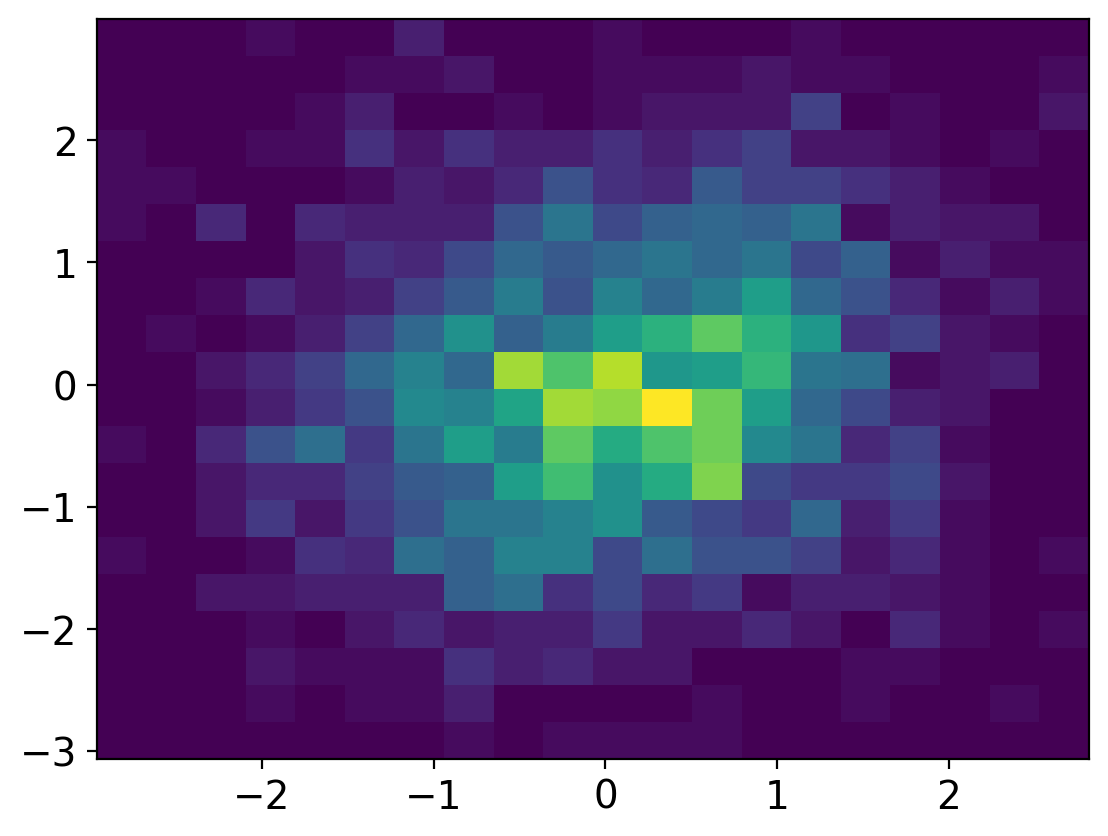

In [7]:
plt.hist2d(samples[:,0], samples[:,1], bins=20)

plt.show()